## Campos involucrados

- escuelascercanas
- centroscomercialescercanos
- idzona

## Ideas

- Agregar info externa (transporte cercano? barrios "de moda"?)
- Caracterización de zona
  - Centro Geográfico
  - ¿diámetro?
  - Promedios
    - metroscubiertos
    - precio
    - ...
- Armar un dataframe con info de zonas?


## Problema

- Dado un grupo de coordenadas geográficas, no es tan sencillo calcular áreas y distancias (habría que proyectar). 

__Hay publicaciones cuyas coordenadas son demasiado lejanas a las del resto de la zona__
¿Cómo las encuentro?
- Distancia al centro de la zona (¿promedio de latitud-longitud u otra medida?)


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point, Polygon
import numpy

In [96]:
# importo las funciones para levantar los dataframes
%run "../../utils/dataset_parsing.ipynb"
# importo las funciones para graficar
%run "../../utils/graphs.ipynb"

In [126]:
pd.set_option("display.max_colwidth", -1)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [22]:
# cargo el dataset
df = levantar_datos("../../"+DATASET_RELATIVE_PATH)
df.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio', 'mes', 'ano', 'dia',
       'precio_metro_cubierto', 'precio_metro_total', 'gps'],
      dtype='object')

In [61]:
pais = geopandas.read_file("./MEX_adm/MEX_adm0.shp")
estados = geopandas.read_file("./MEX_adm/MEX_adm1.shp")

In [23]:
def agg_polygon(point_series):
    """
        Recibe un pd.Series de geometry.Point
        Devuelve un Polygon de los puntos de la serie, o NaN si
        no tiene suficientes puntos (3).
    """
    values = point_series.loc[~point_series.isna()].values
    if len(values) < 3: return numpy.NaN
    return Polygon([[p.x, p.y] for p in values])

## Armo un Dataframe donde las filas son las zonas

In [24]:
calculations = ["mean","std","max","min"]
aggregations = {"id": "count",\
                "precio_metro_total": calculations,\
                "precio_metro_cubierto": calculations,\
                "antiguedad": calculations,\
                "habitaciones": calculations,\
                "metroscubiertos": calculations,\
                "metrostotales": calculations,\
                "lat": calculations,\
                "lng": calculations,\
                "precio": calculations,\
                "habitaciones": calculations,\
                "garages": calculations,\
                "banos": calculations,\
                "gps": agg_polygon\
               }
zonas = df.groupby(["idzona"]).agg(aggregations)
zonas.columns = [x+"_"+y for x,y in zonas.columns]
zonas.rename({"gps_agg_polygon": "polygon"}, axis="columns", inplace=True)

In [25]:
zonas["lat_dif"] = zonas["lat_max"] - zonas["lat_min"]
zonas["lng_dif"] = zonas["lng_max"] - zonas["lng_min"]

In [27]:
zonas.shape

(19719, 48)

In [26]:
zonas

,id_count,precio_metro_total_mean,precio_metro_total_std,precio_metro_total_max,precio_metro_total_min,precio_metro_cubierto_mean,precio_metro_cubierto_std,precio_metro_cubierto_max,precio_metro_cubierto_min,antiguedad_mean,...,garages_std,garages_max,garages_min,banos_mean,banos_std,banos_max,banos_min,polygon,lat_dif,lng_dif
idzona,,,,,,,,,,,,,,,,,,,,,
22.0,15,22044.491681,11082.393826,40079.365079,5865.000000,24215.438553,13060.759829,46666.666667,5190.311419,2.533203,...,0.729980,2.0,0.0,2.000000,0.816406,3.0,1.0,POLYGON ((-99.22817462858886 18.95574378639903...,0.486132,0.104702
23.0,26,8136.115904,3078.807635,15000.000000,4010.416667,6918.916093,2533.223702,13793.103448,3843.750000,10.953125,...,0.927734,3.0,0.0,2.226562,0.922363,4.0,1.0,POLYGON ((-102.3020817302246 21.88021291134348...,0.027350,0.019965
26.0,10,5617.013889,2043.191336,10312.500000,2300.000000,6492.125563,1341.220141,8625.000000,4204.545455,20.109375,...,0.601074,2.0,0.0,2.222656,0.666504,3.0,1.0,POLYGON ((-102.3220805097534 21.89672462746231...,0.015620,0.004621
27.0,1,6190.476190,NaN,6190.476190,6190.476190,7222.222222,NaN,7222.222222,7222.222222,10.000000,...,NaN,1.0,1.0,1.000000,NaN,1.0,1.0,NaN,NaN,NaN
28.0,2,6875.000000,4419.417382,10000.000000,3750.000000,5481.004902,1122.185394,6274.509804,4687.500000,17.500000,...,0.707031,2.0,1.0,2.000000,0.000000,2.0,2.0,NaN,0.008701,0.021809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50003995.0,2539,31125.395210,16799.741113,263333.333333,2559.055118,28972.193461,10915.047825,160000.000000,2559.055118,11.132812,...,0.770020,3.0,0.0,2.095703,0.731934,4.0,1.0,POLYGON ((-99.14951912584229 19.37489491782334...,25.434865,202.891573
50003996.0,973,24093.175221,9263.152455,82600.000000,3821.656051,24018.886763,10186.210975,134146.341463,4543.859649,8.914062,...,0.695801,3.0,0.0,1.762695,0.601074,4.0,1.0,"POLYGON ((-99.1491269 19.3702717, -99.15136456...",25.437594,100.989118
50003997.0,1409,27575.261757,11816.276546,144526.315789,3872.832370,27135.401129,10322.665730,68353.333333,2975.000000,10.773438,...,0.770020,3.0,0.0,1.898438,0.640137,4.0,1.0,POLYGON ((-99.15844229657284 19.38491669565824...,19.990059,99.872282


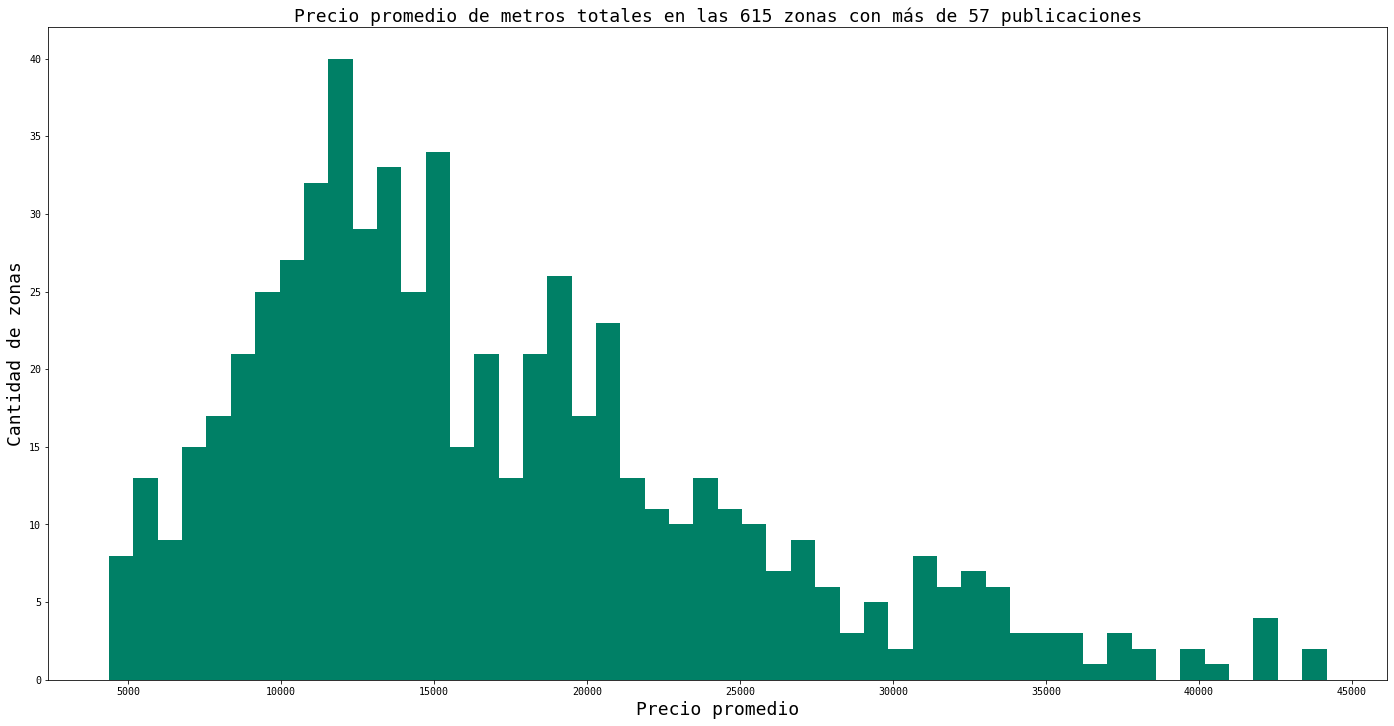

In [105]:
# analizo precios promedio por zona
minima_cantidad_publicaciones = zonas["id_count"].mean() + zonas["id_count"].std()
zonas_con_mas_publicaciones = zonas.loc[zonas["id_count"] > minima_cantidad_publicaciones ]
titulo = "Precio promedio de metros totales en las {} zonas con más de {} publicaciones".format(zonas_con_mas_publicaciones.shape[0], int(minima_cantidad_publicaciones))
plot = get_hist(zonas_con_mas_publicaciones["precio_metro_total_mean"], title=titulo, size=(24,12), xlabel="Precio promedio", ylabel="Cantidad de zonas")
plot.figure.savefig("../graficos/hist_precios_zonas")

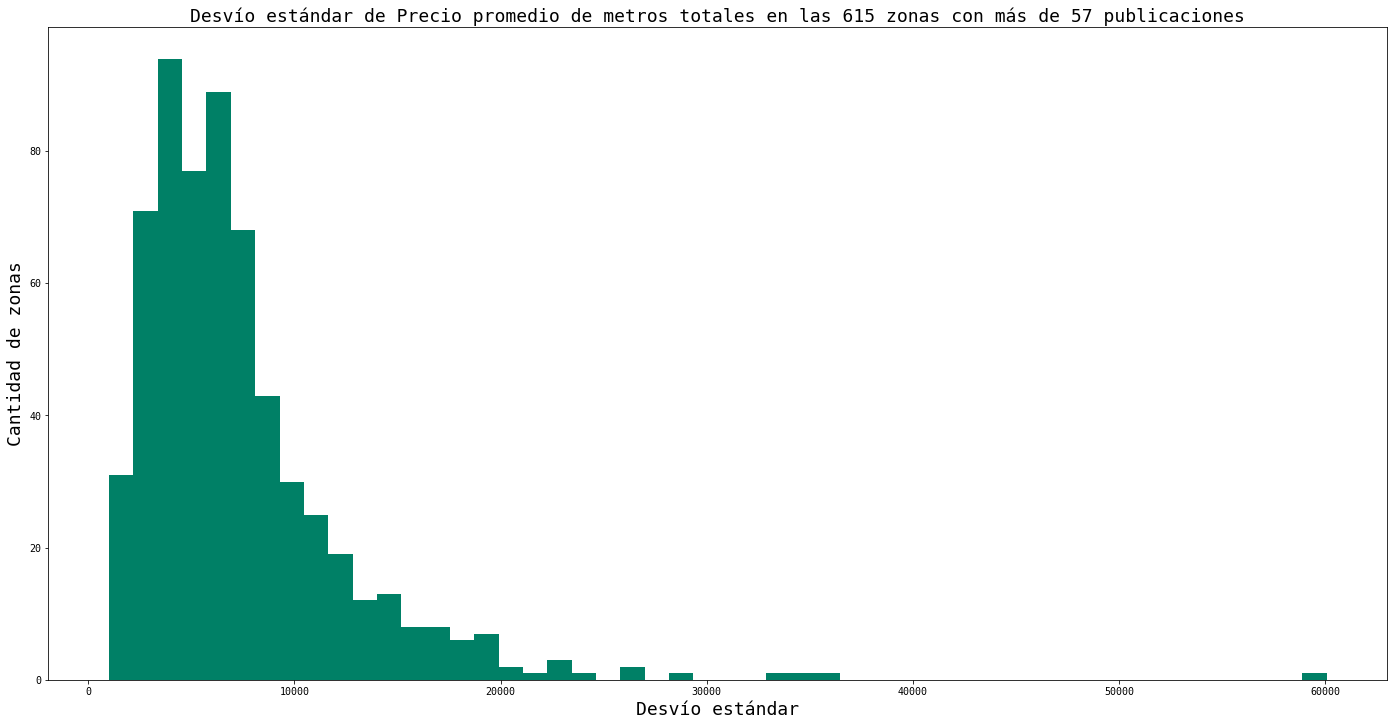

In [113]:
titulo = "Desvío estándar de Precio promedio de metros totales en las {} zonas con más de {} publicaciones".format(zonas_con_mas_publicaciones.shape[0], int(minima_cantidad_publicaciones))
plot = get_hist(zonas_con_mas_publicaciones["precio_metro_total_std"], title=titulo, size=(24,12), xlabel="Desvío estándar", ylabel="Cantidad de zonas")
plot.figure.savefig("../graficos/hist_desvio_precios_zonas")

In [ ]:
# agrego info de zonas a df estados
zonas_por_estado = df.groupby(["provincia"]).agg({"idzona":"nunique"})
zonas_por_estado.columns = ["cantidad_zonas"]
estados = estados.merge(left_on="NAME_1", right_on="provincia", right=zonas_por_estado, how="left")
estados["cantidad_zonas"] = estados["cantidad_zonas"].fillna(0).astype(int)

In [53]:
estados[["NAME_1","cantidad_zonas"]]

,NAME_1,cantidad_zonas
0,Aguascalientes,1398
1,Baja California Sur,1541
2,Baja California,0
3,Campeche,226
4,Chiapas,951
5,Chihuahua,3347
6,Coahuila,3189
7,Colima,843
8,Distrito Federal,55744
9,Durango,1877


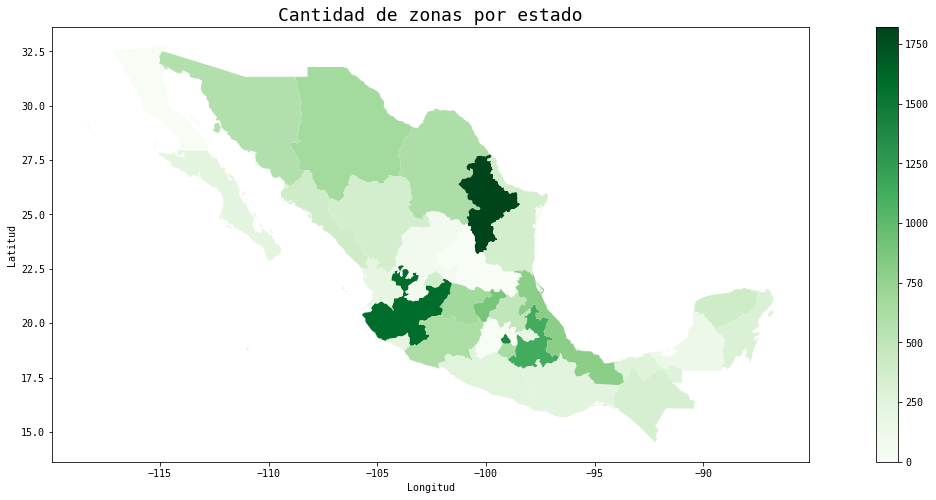

In [64]:
plot = estados.plot(column="cantidad_zonas", legend=True, figsize=(24,8), cmap="Greens")    
plot.set_title("Cantidad de zonas por estado", fontdict={"fontsize": 18})
plot.set_xlabel("Longitud")
plot.set_ylabel("Latitud")
plot.figure.savefig("../graficos/map_zonas_por_estado.png")

In [8]:
zonas[["lat_dif","lng_dif"]].describe()

,lat_dif,lng_dif
count,14967.000000,14967.000000
mean,0.594770,2.871664
std,3.734928,18.934023
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.001700,0.001790
75%,0.021283,0.023301
max,102.820840,220.917327


In [9]:
zonas_ok = zonas.loc[(zonas["lat_dif"] < zonas["lat_dif"].mean()) & (zonas["lng_dif"] < zonas["lng_dif"].mean())]
zonas_ok.shape

(14255, 48)

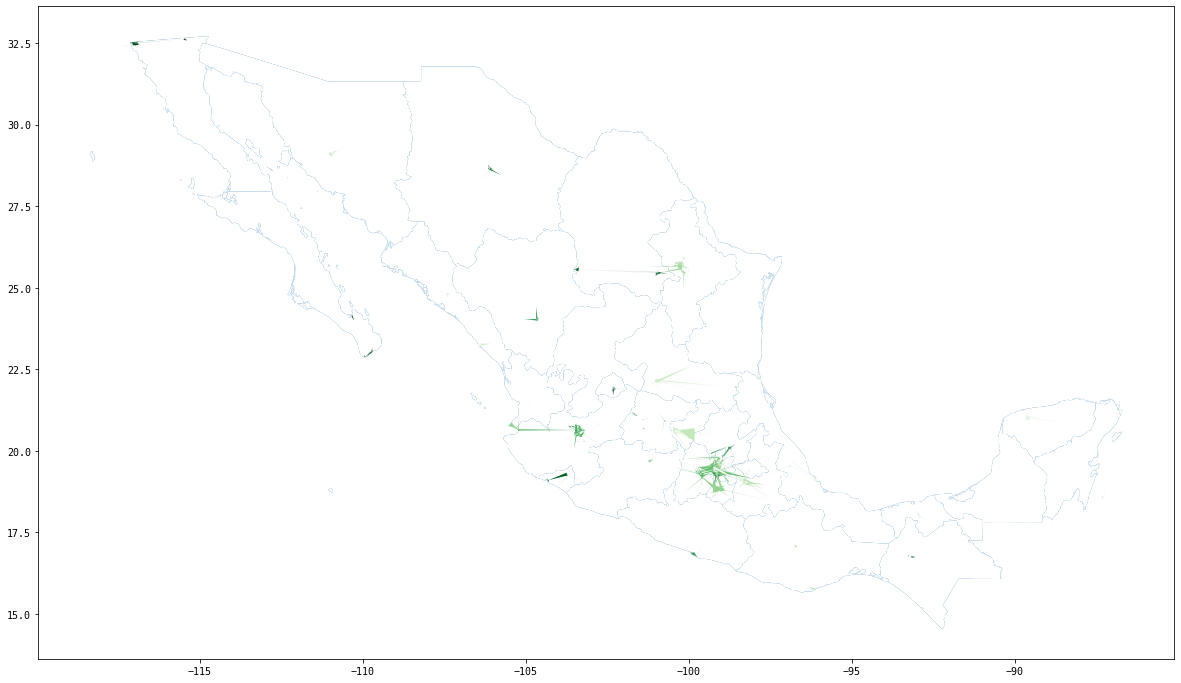

In [11]:
con_polygon = zonas_ok.loc[~zonas["polygon"].isna()]
geoDF = geopandas.GeoDataFrame(con_polygon, geometry="polygon")
base = pais.plot(figsize=(24,12))
estados_plot = estados.plot(ax=base, color="white")
plot = geoDF.plot(ax=estados_plot, cmap="Greens_r")

In [12]:
zonas_ok.loc[:,"centroid"] = con_polygon["polygon"].map(lambda x: x.buffer(0).representative_point())

c:\users\dev\repos\fiuba\75-06\2019-2\tp\.venv\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\dev\repos\fiuba\75-06\2019-2\tp\.venv\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [13]:
zonas_ok.sort_values(by="id_count", ascending=False).head(5)

,id_count,precio_metro_total_mean,precio_metro_total_std,precio_metro_total_max,precio_metro_total_min,precio_metro_cubierto_mean,precio_metro_cubierto_std,precio_metro_cubierto_max,precio_metro_cubierto_min,antiguedad_mean,...,garages_max,garages_min,banos_mean,banos_std,banos_max,banos_min,polygon,lat_dif,lng_dif,centroid
idzona,,,,,,,,,,,,,,,,,,,,,
84028.0,610,11009.720104,2582.311642,22413.793103,1903.278431,10880.046508,1975.915696,22413.793103,2929.687500,0.420654,...,3.0,0.0,2.423828,0.643555,4.0,1.0,"POLYGON ((-100.3527645060547 20.6460038109047,...",0.439569,0.648001,POINT (-100.3437176659128 20.66163777457627)
24823.0,575,19349.931317,8530.907233,60000.000000,2176.470588,17162.627796,9533.312801,200000.000000,2418.300654,7.921875,...,3.0,0.0,2.041016,0.800293,4.0,1.0,POLYGON ((-99.19589997523805 19.27962060115258...,0.371646,0.193023,POINT (-99.12874653703395 19.30185404737162)
339455.0,513,12921.119017,5081.532061,41089.108911,2876.543210,12027.004663,4231.243196,35047.619048,3030.303030,2.246094,...,3.0,0.0,2.412109,0.698242,4.0,1.0,"POLYGON ((-100.3482241 20.5986037, -100.343208...",0.115853,0.130680,POINT (-100.379565930118 20.58925242032455)
343015.0,503,12290.126879,3941.583475,33333.333333,3500.000000,11698.947261,2778.120084,33333.333333,6209.935897,3.583984,...,3.0,0.0,2.375000,0.751465,4.0,1.0,"POLYGON ((-101.0400145 22.1500569, -101.028715...",0.516280,1.181095,POINT (-100.4276075880365 22.37975053566156)
47735.0,442,18846.159074,4613.109616,33108.108108,5510.460251,16350.122465,2760.791604,26870.748299,7242.990654,0.967773,...,3.0,0.0,3.214844,0.741699,4.0,1.0,POLYGON ((-103.4538077171875 20.71414000228824...,0.433882,1.816837,POINT (-103.4608073235448 20.7270232686519)


In [14]:
publicaciones_84028 = df.loc[df["idzona"]==84028.0] 
publicaciones_84028.head(1)

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,piscina,escuelascercanas,centroscomercialescercanos,precio,mes,ano,dia,precio_metro_cubierto,precio_metro_total,gps
82,18684,oportunidad unica el refugio 3 rec con vestido...,hermosas y unicas residencias nuevas en el ref...,Casa en condominio,RESIDENCIAL DIAMANTE,Querétaro,Querétaro,0.0,3.0,2.0,...,True,True,True,1300000.0,8,2015,21,12037.037037,13265.306122,POINT (-100.3527645060547 20.6460038109047)


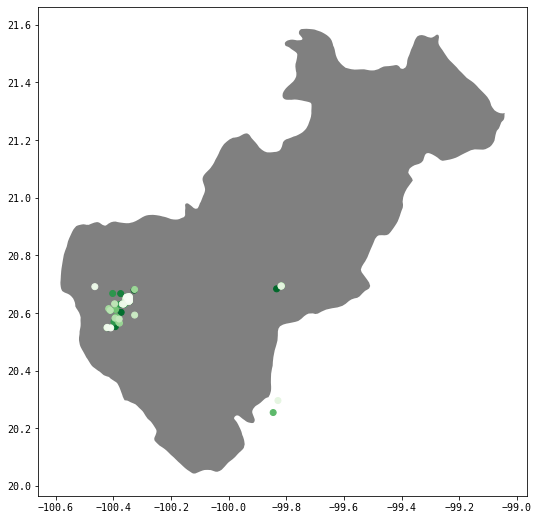

In [15]:
geoDF = geopandas.GeoDataFrame(publicaciones_84028, geometry="gps")
queretaro = estados.loc[estados["NAME_1"]=="Querétaro"].plot(figsize=(18,9),color="gray")
plot = geoDF.plot(ax=queretaro, cmap="Greens_r")

In [130]:
df.loc[(df.idzona.isna()) & (~df.lat.isna())].shape

(11445, 29)

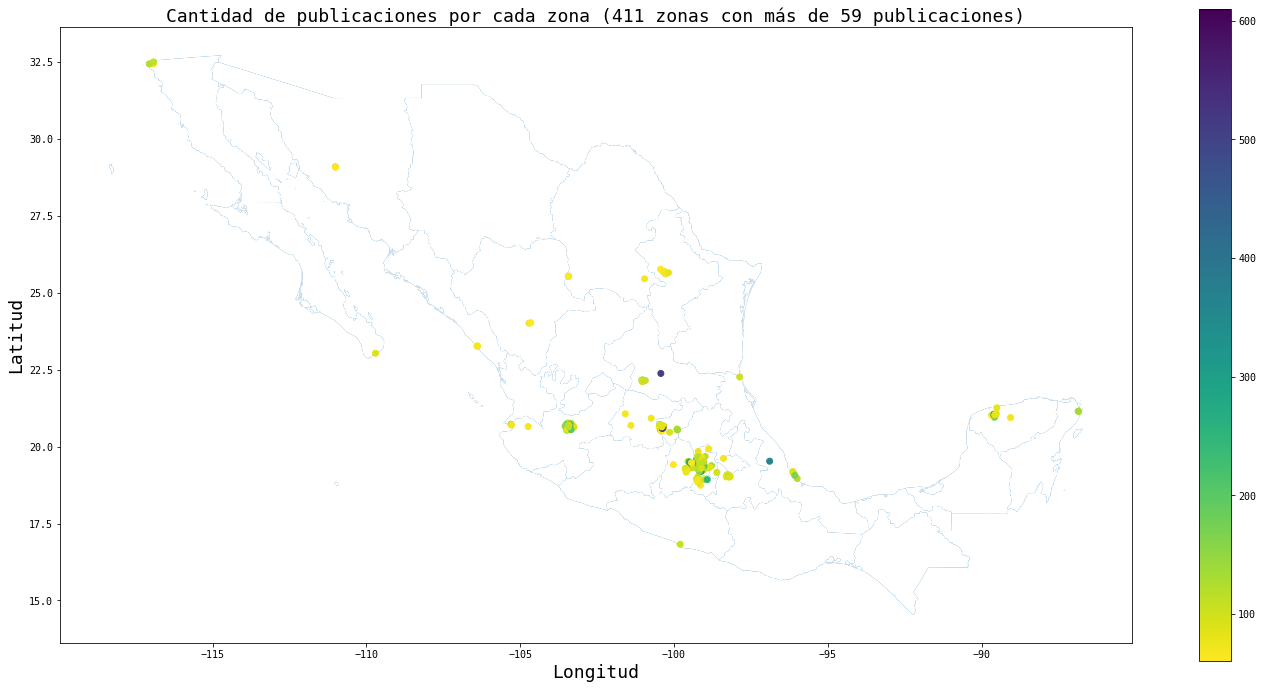

In [132]:
def plot_mexico(df, geometry, columna, titulo):
    geoDF = geopandas.GeoDataFrame(df, geometry=geometry)
    base = pais.plot(figsize=(24,12))
    estados_plot = estados.plot(ax=base, color="white")
    plot = geoDF.plot(ax=estados_plot, cmap="viridis_r",legend=True, column=columna)
    plot.set_title(titulo, fontdict={"fontsize": 18})
    plot.set_xlabel("Longitud", fontdict={"fontsize": 18})
    plot.set_ylabel("Latitud", fontdict={"fontsize": 18})
    return plot
    
con_centroide = zonas_ok.loc[(~zonas_ok["centroid"].isna())]
en_mexico = con_centroide.loc[con_centroide["centroid"].map(esta_en_mexico)]
publicaciones_minimas = en_mexico["id_count"].mean() + en_mexico["id_count"].std()
en_mexico = en_mexico.loc[en_mexico["id_count"] > publicaciones_minimas]

msg_minimo = " ({} zonas con más de {} publicaciones)".format(en_mexico.shape[0], int(publicaciones_minimas))

id_count = plot_mexico(en_mexico, "centroid", "id_count", "Cantidad de publicaciones por cada zona"+msg_minimo)
id_count.figure.savefig("../graficos/map_zonas_mas_publicaciones.png")
# precio_metro_cubierto_mean = plot_mexico(en_mexico, "centroid", "precio_metro_cubierto_mean", "Promedio de precio por metro cubierto en cada zona"+msg_minimo)
# precio_metro_total_mean = plot_mexico(en_mexico, "centroid", "precio_metro_total_mean", "Promedio de precio por metro total en cada zona"+msg_minimo)

count    411.000000
mean     124.554745
std       81.309939
min       60.000000
25%       71.000000
50%       99.000000
75%      139.000000
max      610.000000
Name: id_count, dtype: float64

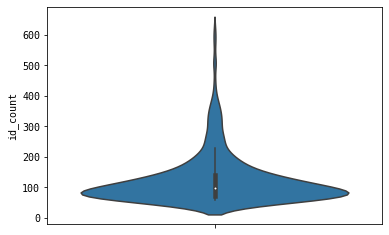

In [17]:
cantidad_publicaciones_por_zona = sns.violinplot(en_mexico["id_count"], orient="v")
en_mexico["id_count"].describe()

### Correlaciones

In [18]:
en_mexico[["id_count","precio_metro_total_mean","precio_metro_cubierto_mean","antiguedad_mean","lat_mean"]].corr()

,id_count,precio_metro_total_mean,precio_metro_cubierto_mean,antiguedad_mean,lat_mean
id_count,1.000000,0.151501,0.157372,-0.023426,-0.067817
precio_metro_total_mean,0.151501,1.000000,0.946872,0.353169,-0.314916
precio_metro_cubierto_mean,0.157372,0.946872,1.000000,0.265573,-0.324169
antiguedad_mean,-0.023426,0.353169,0.265573,1.000000,-0.311457
lat_mean,-0.067817,-0.314916,-0.324169,-0.311457,1.000000


In [19]:
en_mexico.columns

Index(['id_count', 'precio_metro_total_mean', 'precio_metro_total_std',
       'precio_metro_total_max', 'precio_metro_total_min',
       'precio_metro_cubierto_mean', 'precio_metro_cubierto_std',
       'precio_metro_cubierto_max', 'precio_metro_cubierto_min',
       'antiguedad_mean', 'antiguedad_std', 'antiguedad_max', 'antiguedad_min',
       'habitaciones_mean', 'habitaciones_std', 'habitaciones_max',
       'habitaciones_min', 'metroscubiertos_mean', 'metroscubiertos_std',
       'metroscubiertos_max', 'metroscubiertos_min', 'metrostotales_mean',
       'metrostotales_std', 'metrostotales_max', 'metrostotales_min',
       'lat_mean', 'lat_std', 'lat_max', 'lat_min', 'lng_mean', 'lng_std',
       'lng_max', 'lng_min', 'precio_mean', 'precio_std', 'precio_max',
       'precio_min', 'garages_mean', 'garages_std', 'garages_max',
       'garages_min', 'banos_mean', 'banos_std', 'banos_max', 'banos_min',
       'polygon', 'lat_dif', 'lng_dif', 'centroid'],
      dtype='object')